### Import Libraries


In [ ]:
!pip install -U tensorflow==2.14.0

  Obtaining dependency information for tensorflow==2.14.0 from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/packages/d1/1d/d5cf76e5e40f69dbd273036e3172ae4a614577cb141673427b80cac948df/ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
  Obtaining dependency information for tensorboard<2.15,>=2.14 from https://files.pythonhosted.org/packages/73/a2/66ed644f6ed1562e0285fcd959af17670ea313c8f331c46f79ee77187eb9/tensorboard-2.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-estimator<2.15,>=2.14.0 from https://files.pythonhosted.org/packages/d1/da/4f264c196325bb6e37a6285caec5b12a03def489b57cc1fdac02bb6272cd/tensor

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import some other useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [13]:
pip install keras_cv

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
os.listdir('/kaggle/input/')

['dataset']

In [5]:
data = np.load('/kaggle/input/dataset/balanced_dataset/dataset.npz',allow_pickle=True)
lst = data.files
X = data[lst[0]]
y = data[lst[1]]

# Convert values in data to int
X = X.astype(int)

### Create train and validation sets

In [6]:
# Normalize data to the range [0, 1]
X_train_val = (X / 255).astype('float32')

# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array([map[label.decode()] for label in y])

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(int_labels)


# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

del X_train_val, y_train_val

In this analysis, we assess the effectiveness of ConvNeXtTiny, incorporating a fully convolutional section enriched with BatchNormalization and DropOut layers. To enhance the model's robustness, data augmentation is employed using the randaug layer from the keras_cv library. The augmentation strategy includes two default transformations: Zoom and Flip.

In [7]:
convnext = tf.keras.applications.ConvNeXtTiny(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
    #pooling='avg',
    classes=2,
    classifier_activation='softmax',
)
convnext.trainable = False

111650432/111650432 [==============================] - 1s 0us/step


The ConvNeXtTiny model leverages a fully convolutional section, reinforcing its capacity for feature extraction and representation. The integration of BatchNormalization layers aids in normalizing intermediate representations, promoting stable and efficient training. Additionally, DropOut layers are strategically inserted to prevent overfitting and enhance generalization.

In this study, the randaug layer from the keras_cv library is employed for data augmentation. This layer facilitates the application of random augmentations during training, enhancing the diversity of the training dataset.

Two fundamental augmentations are incorporated by default:

    Zoom: This augmentation technique involves randomly zooming into images, introducing variations in scale and perspective. This enriches the dataset and allows the model to learn robust features under different spatial configurations.

    Flip: Image flipping, both horizontally and vertically, is applied randomly. This augmentation helps the model become invariant to the orientation of objects in the images, thereby enhancing its ability to recognize patterns from various viewpoints.

In [8]:
import keras_cv.layers as kcvl

def build_convnext_with_augmentation(input_shape=(96, 96, 3), dropout_rate=0.2):
    tf.random.set_seed(seed)
    img_augmentation = tf.keras.Sequential(
        [
            kcvl.RandAugment(
                value_range=(0, 1),
                augmentations_per_image=3,
                magnitude=0.3,
                magnitude_stddev=0.15,
                rate=0.9090909090909091,
                geometric=True,
                seed=seed),
            tfkl.RandomFlip(),
            tfkl.RandomZoom(height_factor=(-0.15, 0.2), width_factor=(-0.15, 0.2)),
        ],
        name="img_augmentation",
    )
    
    inputs = tfk.Input(shape=input_shape)
    augmentation = img_augmentation(inputs)
    augmented_255 = tf.cast(augmentation * 255, tf.uint8)
    
    x1 = convnext(augmented_255)
    # x1 = convnext(inputs)  # Se vuoi usare l'input originale senza la rand augmentation 

    x2 = tfkl.GlobalAveragePooling2D(name="avg_pool")(x1)
    x3 = tfkl.BatchNormalization()(x2)

    # Applica Batch Normalization e Dropout a tutti i layer densi
    intermediate1 = tfkl.Dense(64, activation=None, kernel_initializer='he_normal')(x3)
    intermediate1 = tfkl.BatchNormalization()(intermediate1)
    intermediate1 = tfkl.Activation(tf.keras.activations.swish)(intermediate1)
    intermediate1 = tfkl.Dropout(dropout_rate)(intermediate1)

    intermediate2 = tfkl.Dense(128, activation=None, kernel_initializer='he_normal')(intermediate1)
    intermediate2 = tfkl.BatchNormalization()(intermediate2)
    intermediate2 = tfkl.Activation(tf.keras.activations.swish)(intermediate2)
    intermediate2 = tfkl.Dropout(dropout_rate)(intermediate2)

    intermediate3 = tfkl.Dense(256, activation=None, kernel_initializer='he_normal')(intermediate2)
    intermediate3 = tfkl.BatchNormalization()(intermediate3)
    intermediate3 = tfkl.Activation(tf.keras.activations.swish)(intermediate3)
    intermediate3 = tfkl.Dropout(dropout_rate)(intermediate3)

    intermediate4 = tfkl.Dense(512, activation=None, kernel_initializer='he_normal')(intermediate3)
    intermediate4 = tfkl.BatchNormalization()(intermediate4)
    intermediate4 = tfkl.Activation(tf.keras.activations.swish)(intermediate4)
    intermediate4 = tfkl.Dropout(dropout_rate)(intermediate4)

    intermediate7 = tfkl.Dense(256, activation=None, kernel_initializer='he_normal')(intermediate4)
    intermediate7 = tfkl.BatchNormalization()(intermediate7)
    intermediate7 = tfkl.Activation(tf.keras.activations.swish)(intermediate7)
    intermediate7 = tfkl.Dropout(dropout_rate)(intermediate7)

    intermediate8 = tfkl.Dense(64, activation=None, kernel_initializer='he_normal')(intermediate7)
    intermediate8 = tfkl.BatchNormalization()(intermediate8)
    intermediate8 = tfkl.Activation(tf.keras.activations.swish)(intermediate8)
    intermediate8 = tfkl.Dropout(dropout_rate)(intermediate8)

    intermediate9 = tfkl.Dense(32, activation=None, kernel_initializer='he_normal')(intermediate8)
    intermediate9 = tfkl.BatchNormalization()(intermediate9)
    intermediate9 = tfkl.Activation(tf.keras.activations.swish)(intermediate9)
    intermediate9 = tfkl.Dropout(dropout_rate)(intermediate9)

    intermediate10 = tfkl.Dense(8, activation=None, kernel_initializer='he_normal')(intermediate9)
    intermediate10 = tfkl.BatchNormalization()(intermediate10)
    intermediate10 = tfkl.Activation(tf.keras.activations.swish)(intermediate10)
    intermediate10 = tfkl.Dropout(dropout_rate)(intermediate10)
    
    outputs = tfkl.Dense(2, activation='softmax')(intermediate10)

    # Crea un Model collegando input e output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compila il modello con Categorical Cross-Entropy loss e Lion optimizer
    optimizer = tf.keras.optimizers.Lion(learning_rate=1e-4)
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Restituisci il modello
    return model


Using TensorFlow backend


In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  
    else:
        return lr * tf.math.exp(-0.1) 

lr_schedule = LearningRateScheduler(lr_scheduler)

In [10]:
tl_model = build_convnext_with_augmentation()

tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        lr_schedule  
    ]
).history

Epoch 1/100
173/173 [==============================] - 77s 267ms/step - loss: 0.7702 - accuracy: 0.5401 - val_loss: 0.6529 - val_accuracy: 0.6176 - lr: 1.0000e-04
Epoch 2/100
173/173 [==============================] - 33s 194ms/step - loss: 0.6792 - accuracy: 0.6055 - val_loss: 0.5979 - val_accuracy: 0.6895 - lr: 1.0000e-04
Epoch 3/100
173/173 [==============================] - 34s 194ms/step - loss: 0.6056 - accuracy: 0.6777 - val_loss: 0.5588 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 4/100
173/173 [==============================] - 34s 194ms/step - loss: 0.5693 - accuracy: 0.7053 - val_loss: 0.5050 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 5/100
173/173 [==============================] - 33s 190ms/step - loss: 0.5362 - accuracy: 0.7309 - val_loss: 0.4851 - val_accuracy: 0.7631 - lr: 1.0000e-04
Epoch 6/100
173/173 [==============================] - 33s 193ms/step - loss: 0.5480 - accuracy: 0.7282 - val_loss: 0.4969 - val_accuracy: 0.7598 - lr: 1.0000e-04
Epoch 7/100
173/173 [=

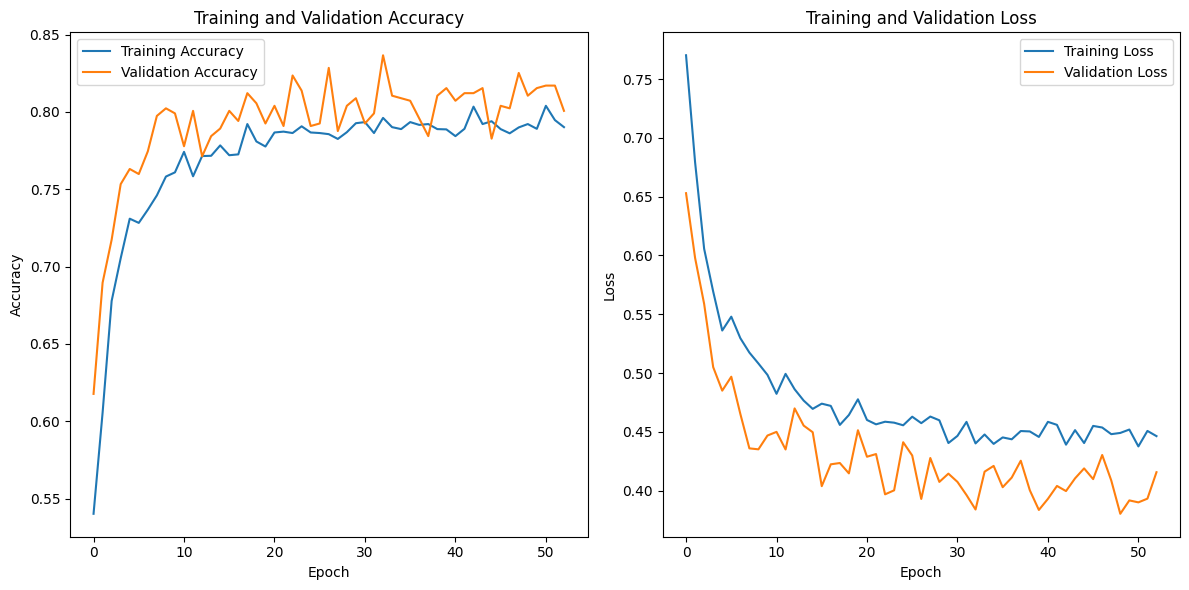

In [11]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(tl_history['accuracy'], label='Training Accuracy')
plt.plot(tl_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(tl_history['loss'], label='Training Loss')
plt.plot(tl_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
model_name = 'convnext_TL'
print("Finished training of ", model_name, " model")
tl_model.save(model_name)

Finished training of  convnext_TL  model


In [13]:
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []

last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

best_val_accuracy = last_val_accuracy
best_model = model_name

print("Last model has reached")
print("Train loss: ", last_train_loss)
print("Train accuracy: ", last_train_accuracy)
print("Validation loss: ", last_val_loss)
print("Validation accuracy: ", last_val_accuracy)

173/173 [==============================] - 28s 162ms/step - loss: 0.3837 - accuracy: 0.8266
Last model has reached
Train loss:  0.3836931884288788
Train accuracy:  0.8266158103942871
Validation loss:  0.4192661941051483
Validation accuracy:  0.7908496856689453


# Fine Tuning - all

To further enhance the adaptability of ConvNeXtTiny to our specific task, a fine-tuning strategy has been employed. In our case, all layers of the model, including the convolutional, BatchNormalization, and DropOut layers, are designated as trainable during fine-tuning.

In [14]:
# Set all layers as trainable
tl_model.trainable = True

if all(layer.trainable for layer in tl_model.layers):
    print("Successful!")
else:
    print("Error!")

Successful!


In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  
    else:
        return lr * tf.math.exp(-0.1)
    
lr_schedule = LearningRateScheduler(lr_scheduler)

In [16]:
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(5e-5), metrics=['accuracy'])

In [17]:
# Train the model
print("All layers are training.")

tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        lr_schedule  
    ]
).history

All layers are training.
Epoch 1/200
173/173 [==============================] - 92s 330ms/step - loss: 0.4419 - accuracy: 0.7947 - val_loss: 0.5026 - val_accuracy: 0.7696 - lr: 5.0000e-05
Epoch 2/200
173/173 [==============================] - 48s 280ms/step - loss: 0.4114 - accuracy: 0.8172 - val_loss: 0.3269 - val_accuracy: 0.8497 - lr: 5.0000e-05
Epoch 3/200
173/173 [==============================] - 47s 271ms/step - loss: 0.4839 - accuracy: 0.7736 - val_loss: 0.4150 - val_accuracy: 0.8039 - lr: 5.0000e-05
Epoch 4/200
173/173 [==============================] - 47s 273ms/step - loss: 0.4584 - accuracy: 0.7861 - val_loss: 0.4203 - val_accuracy: 0.8154 - lr: 5.0000e-05
Epoch 5/200
173/173 [==============================] - 47s 273ms/step - loss: 0.4004 - accuracy: 0.8246 - val_loss: 0.3578 - val_accuracy: 0.8252 - lr: 5.0000e-05
Epoch 6/200
173/173 [==============================] - 47s 273ms/step - loss: 0.3914 - accuracy: 0.8328 - val_loss: 0.3701 - val_accuracy: 0.8366 - lr: 5.0000e-

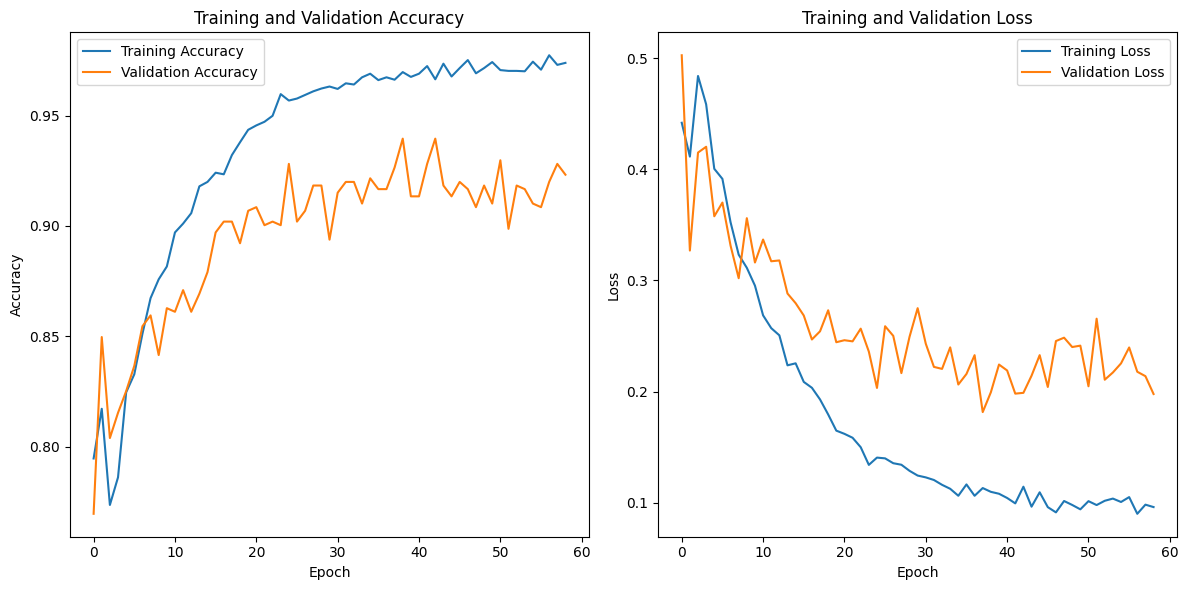

In [18]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(tl_history['accuracy'], label='Training Accuracy')
plt.plot(tl_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(tl_history['loss'], label='Training Loss')
plt.plot(tl_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

print("Last model has reached")
print("Train loss: ", last_train_loss)
print("Train accuracy: ", last_train_accuracy)
print("Validation loss: ", last_val_loss)
print("Validation accuracy: ", last_val_accuracy)

173/173 [==============================] - 27s 155ms/step - loss: 0.0771 - accuracy: 0.9744
Last model has reached
Train loss:  0.07707928866147995
Train accuracy:  0.9744008779525757
Validation loss:  0.20050667226314545
Validation accuracy:  0.9183006286621094


In [20]:
model_name = 'convnext_FTall'
print("Finished training of ", model_name, " model")
tl_model.save(model_name)

Finished training of  convnext_FTall  model


In [21]:
if best_val_accuracy <= last_val_accuracy: # current model is better than the previous one
    best_val_accuracy = last_val_accuracy
    best_model = model_name
else: 
    print("No improvement with current model...")
    print("Best model is still ", best_model, ": reloading it!")
    tl_model = tfk.models.load_model(best_model)

In [22]:
print("Saving best model")
tl_model.save('best')

Saving best model


In [23]:
best_val_loss, best_val_accuracy = tl_model.evaluate(X_val, y_val)
best_train_loss, best_train_accuracy = tl_model.evaluate(X_train, y_train)
best_model_data = np.array([[best_val_loss, best_val_accuracy, best_train_loss, best_train_accuracy]])

173/173 [==============================] - 27s 156ms/step - loss: 0.0850 - accuracy: 0.9699


# Output history

In [24]:
data = np.array([val_loss, val_accuracy, train_loss, train_accuracy])
best_model_data = np.array(best_model_data)

# Transpose the array so that each metric is in a separate row
data = data.T

# Define the header for the columns
header = "val_loss\tval_accuracy\ttrain_loss\ttrain_accuracy"

# Save the data to a text file
np.savetxt('output.txt', data, header=header, comments='', delimiter='\t')

# Append a separator line
with open('output.txt', 'a') as file:
    file.write('\n' + '-'*40 + '\n')

# Append the "Best model" section
np.savetxt('output.txt', best_model_data, header="Best model:", comments='', delimiter='\t', fmt='%s', footer='\n')

# Train also on validation set

In [25]:
# Load best model
tl_model = tfk.models.load_model(best_model)

In [26]:
# Set all layers as trainable
tl_model.trainable = True

if all(layer.trainable for layer in tl_model.layers):
    print("Successful!")
else:
    print("Error!")

Successful!


In [27]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  
    else:
        return lr * tf.math.exp(-0.1) 

lr_schedule = LearningRateScheduler(lr_scheduler)

In [28]:
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(1e-6), metrics=['accuracy'])

In [29]:
# Train the model
print("All layers are training.")
tl_history = tl_model.fit(
    x=X_val,
    y=y_val,
    batch_size=32,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        lr_schedule  
    ]
).history

All layers are training.
Epoch 1/40
20/20 [==============================] - 53s 983ms/step - loss: 0.2547 - accuracy: 0.9199 - val_loss: 0.2349 - val_accuracy: 0.9118 - lr: 1.0000e-06
Epoch 2/40
20/20 [==============================] - 8s 400ms/step - loss: 0.2701 - accuracy: 0.9134 - val_loss: 0.2016 - val_accuracy: 0.9167 - lr: 1.0000e-06
Epoch 3/40
20/20 [==============================] - 8s 402ms/step - loss: 0.2947 - accuracy: 0.9052 - val_loss: 0.1864 - val_accuracy: 0.9314 - lr: 1.0000e-06
Epoch 4/40
20/20 [==============================] - 8s 395ms/step - loss: 0.2726 - accuracy: 0.9118 - val_loss: 0.2250 - val_accuracy: 0.9183 - lr: 1.0000e-06
Epoch 5/40
20/20 [==============================] - 8s 409ms/step - loss: 0.2647 - accuracy: 0.9118 - val_loss: 0.2177 - val_accuracy: 0.9134 - lr: 1.0000e-06
Epoch 6/40
20/20 [==============================] - 10s 511ms/step - loss: 0.2605 - accuracy: 0.9003 - val_loss: 0.2379 - val_accuracy: 0.9118 - lr: 1.0000e-06
Epoch 7/40
20/20 [=

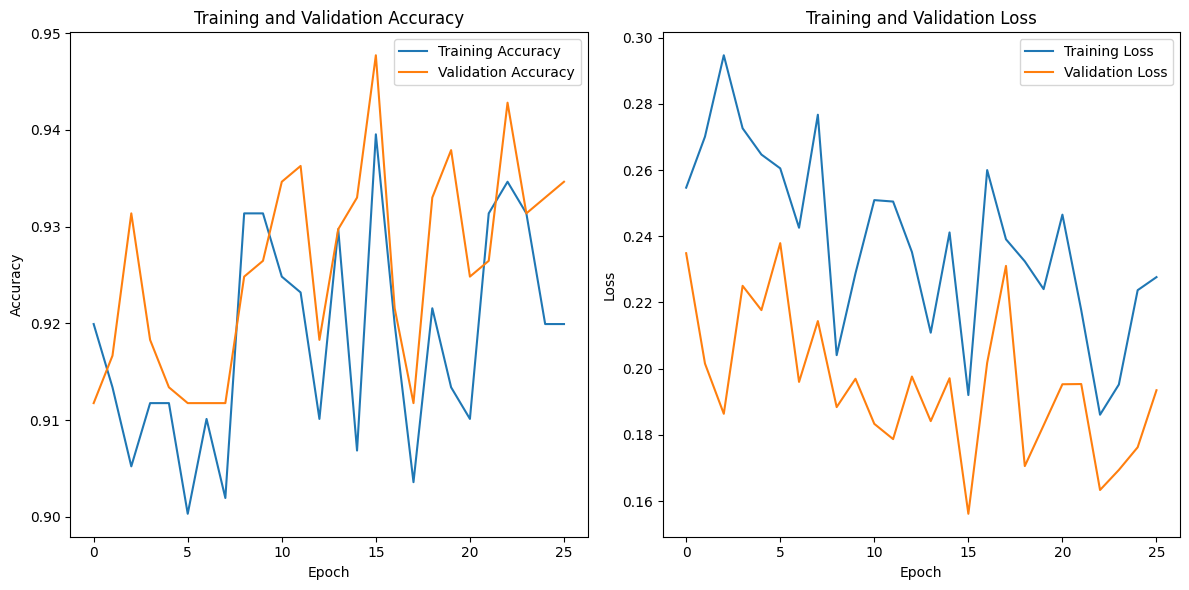

In [30]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(tl_history['accuracy'], label='Training Accuracy')
plt.plot(tl_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(tl_history['loss'], label='Training Loss')
plt.plot(tl_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
model_name = 'convnext_FTval'
print("Finished training of ", model_name, " model")
tl_model.save(model_name)

Finished training of  convnext_FTval  model


In [32]:
last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)

20/20 [==============================] - 3s 160ms/step - loss: 0.1815 - accuracy: 0.9297


In [33]:
if best_val_accuracy <= last_val_accuracy: # current model is better than the previous one
    print("Better performance with training on validation set! ")
else: 
    print("No improvement with training model on validation set...")
    print("Best model is still ", best_model)

Better performance with training on validation set! 


In [34]:
val_model_data = np.array([[last_val_loss, last_val_accuracy]])
with open('output.txt', 'a') as file:
    file.write('\n' + '-'*40 + '\n')

# Append the "Best model" section
np.savetxt('output.txt', val_model_data, header="Model trained on validation:", comments='', delimiter='\t', fmt='%s', footer='\n')